In [25]:
#!pip install geopandas #rasterio

In [26]:
#If on collab
from google.colab import drive
drive.mount('/gdrive')
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/ati_sense_prac')

Mounted at /gdrive
Mounted at /content/drive


In [27]:
#import json
import pandas as pd
import geopandas as gpd
#import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from sys import path
#import time
#from tqdm import tqdm
import glob
import rasterio
from rasterio.plot import show

%matplotlib inline
os.getcwd()
os.path.dirname(os.getcwd())

'/content/drive/My Drive'

# Automated Sentinel-1 Ice, Water, Land Segmentation Challenge



This notebook is the adjusted template, to help guide through the training process. Feel free to use as little or as much of it as you like.

For the purposes of the template, we will assume a *classification* approach, which involves sub-sampling small images from the Sentinel-1 images. There will be notes where code should be adjusted for a *segmentation* approach.

### Dataset preparation - (1) sub-sampling

Sample patches from each TIF image, and find the corresponding label using the Shapefiles. Save each image with a unique ID save in the directory **SAMPLING_DIR**. Save the corresponding meta data in the following format (this could be a CSV file, NumPy array, or some other format), in the directory **META_DIR**:


```
image_id, x, y, label
```

Set the label value as one of "L", "W", "I" as specified in the Shapefiles.

To make it easier to patch the final segmentation back together, it is suggested to use the (x, y) pixel coordinates of the patch, rather than the spatial coordinates.

In [28]:
#curdir = os.path.dirname(os.getcwd())
curdir = os.getcwd()
#curdir = curdir + '/ati_sense_prac'
SAMPLING_DIR = curdir + '/sampling_dir' 
META_DIR = curdir + '/meta_dir'
print(SAMPLING_DIR, META_DIR)

/content/drive/My Drive/ati_sense_prac/sampling_dir /content/drive/My Drive/ati_sense_prac/meta_dir


Some helpful code: reading in a single Sentinel-1 image and the corresponding Shapefile.

In [29]:
# the directory containing all shapefiles - i.e., the location of sea_ice/ 
SHAPEFILE_DIR = curdir + '/EE_Polar_Training_Dataset_v-1-0-0'  

shapefile = SHAPEFILE_DIR + '/Sea_Ice/seaice_s1_20180116t075430.shp' # full name of .shp file

print(shapefile)
# extract the shape ID, for example, 20180116T075430
shp_id = shapefile.split("_")[-1][:-4].upper()
print(shp_id)

# locate the corresponding Sentinel-1 image based on the ID
# this should only return 1 match, which you can confirm
tiff_file = curdir + '/Sentinel geotiffs/S1*_' + shp_id + '*.tif'
print(tiff_file)
#S1B_EW_GRDM_1SDH_20181113T074529_20181113T074629_013583_019254_D382_Orb_Cal_Spk_TC_rgb_8bit

#for name in glob.glob(tiff_file):
#    print(name)

tiff_file = glob.glob(tiff_file)[0]
print(tiff_file)

#tiff_file = #[g for g in tiff_files if shp_id in g]
#tiff_file = tiff_file[0]

/content/drive/My Drive/ati_sense_prac/EE_Polar_Training_Dataset_v-1-0-0/Sea_Ice/seaice_s1_20180116t075430.shp
20180116T075430
/content/drive/My Drive/ati_sense_prac/Sentinel geotiffs/S1*_20180116T075430*.tif
/content/drive/My Drive/ati_sense_prac/Sentinel geotiffs/S1A_EW_GRDM_1SDH_20180116T075430_20180116T075530_020177_0226B9_9FE3_Orb_Cal_Spk_TC_rgb_8bit.tif


Feel free to use other Python packages; but as an example, here we use **geopandas** to read in the Shapefile, and **rasterio** to read the GeoTIFF.

In [30]:
#shape_data = gpd.read_file(SHAPEFILE_DIR + shapefile)
shape_data = gpd.read_file(shapefile)

shape_data.head()

,id,CA,SA,FA,CB,SB,FB,CT,poly_type,area,perimeter,geometry
0,1,99,99,99,99,99,99,99,I,10797710,27049,"POLYGON ((-489524.300 -1426091.270, -488551.97..."
1,2,99,99,99,99,99,99,99,W,77404396626,2078665,"POLYGON ((-386420.098 -1661503.239, -386646.67..."
2,3,99,99,99,99,99,99,99,I,145176122,64674,"POLYGON ((-485920.665 -1506863.657, -483911.10..."
3,4,99,99,99,99,99,99,99,L,10137,572,"POLYGON ((-470402.672 -1412012.139, -470511.58..."
4,5,99,99,99,99,99,99,99,L,1284942354,277299,"POLYGON ((-503153.134 -1606829.784, -503172.44..."


In [31]:
shape_data['geometry'][100]
#print(shape_data['geometry'][1].centroid)
#print(shape_data['geometry'].head())
np.nanmin(shape_data['geometry'])

TypeError: ignored

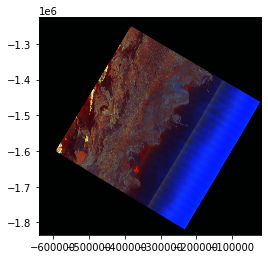

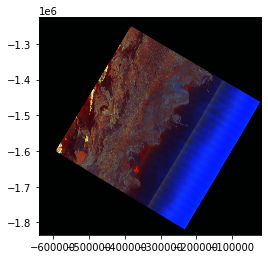

In [32]:
# directory containing all GeoTIFF files
TIFF_DIR = curdir + '\Sentinel geotiffs'  

#tif_img = rasterio.open(TIFF_DIR + tiff_file)
tif_img = rasterio.open(tiff_file)
#tif_img
#plt.imshow(tif_img.read(tif_img), cmap='pink')
#plt.show()
show(tif_img)
show(tif_img.read(), transform=tif_img.transform)

The shapes in the Shapefiles are **shapely** objects. We can also use the Python package **shapely** to check whether an x, y pixel coordinate position is in a given polyshape.

In [33]:
from shapely.geometry import Point
#-489524.300 -1426091.270
x = -214683.0164737697 
y = -1599535.861627199

point = Point(x, y)

# for example, specify the shape in the Shapefile
shape_id = 1

if shape_data['geometry'][shape_id].contains(point):
    print("Point", point, "is in shape", shape_id, "and has class", shape_data['poly_type'][shape_id])


Point POINT (-214683.0164737697 -1599535.861627199) is in shape 1 and has class W


Define a train/validation ratio. Patches and meta saved from the test TIF images should be stored in separate directories.

In [ ]:
TRAIN_SIZE = 0.7

# valid size = 1.0 - TRAIN_SIZE

Map the class category characters to integers.

In [ ]:
LABELS = {
	"L": 0,
	"W": 1,
	"I": 2,
}

The following is a Dataset class which reads in image data saved in the format described above.

In [ ]:
import torch 
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image


class PolarPatch(Dataset):
    def __init__(self, transform=None, split="train"):
        super(PolarPatch, self).__init__()

        assert split in ["train", "val"]
        
        # TODO: load in meta data, which should be of shape (3, N) - N being the number of samples
        meta = []

        train_dim = int(TRAIN_SIZE * len(meta))
        
        if split == "train":
            meta = meta[:train_dim]
        else:
            meta = meta[train_dim:]                   

        self.images = range(len(meta))
        self.coords = [(row[1], row[2]) for row in meta]

        # Targets in integer form for computing cross entropy
        self.targets = [LABELS[row[3]] for row in meta]
        self.transform = transform


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):

        x = Image.open(SAMPLING_DIR + str(self.images[index]) + ".png") # change this file format if needed
        y = self.targets[index]
        coord = self.coords[index]

        if self.transform:
        	x = self.transform(x)

        return x, y, coord

An example data transform

In [ ]:
data_transform = transforms.Compose([
    # TODO: add whatever else you need - normalisation, augmentation, etc.
	transforms.ToTensor(),
])

### Dataset preparation - (2) data loaders

Now we can prepare the data loaders. Here is the example for the training set; you will also need the validation and test set.

In [ ]:
import torch

# TODO set this value based on your working environment
BATCH_SIZE = 128

train_set = PolarPatch(
    split='train',
    transform=data_transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

#Added from other day
test_set = torchvision.datasets.PolarPatch(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

classes = ("L", "W", "I")

In [ ]:
#can disp images using imshow BUT our things have rgb channel at beginning not the end
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    
# get some random training images using the data loader
dataiter = iter(train_loader) #iter creates iterator from it (so if you say next you get the next mini batch)
images, labels = dataiter.next()

# show images and labels
timshow(torchvision.utils.make_grid(images)) # torch vision makes a nice image from it

print(f"labels {[classes[labels[i]] for i in range(10)]}")
#labels = labels of each image
#images = single tensor (16x3x32x32) as has 16 3d structures rep color images

In [ ]:
#this creates graph sturctures on the data
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)
            loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            running_loss += loss
            n += 1
    return running_loss/n, correct/total 

def statsplot(statsrec):
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'r', label = 'training loss', )
    plt.plot(statsrec[1], 'g', label = 'test loss' )
    plt.legend(loc='center')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and test loss, and test accuracy')
    ax2=ax1.twinx()
    ax2.plot(statsrec[2], 'b', label = 'test accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper left')
    plt.show()

### Model

You can use a custom model architecture, or copy one from literature. It is recommended to not build too deep of a network for the sake of training time.

In [ ]:
import torch.nn as nn


class PolarNet(nn.Module):
    def __init__(self, n_classes=3):
        super(PolarNet, self).__init__()

        self.features = nn.Sequential(
            # TODO: build your own architecture here; one conv layer and ReLU here as an example only
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
        )

        self.classifier = nn.Sequential(
            # TODO: continue classifier section of architecture here for classification approach;
            # otherwise, remove and add in upscaling for a fully-convolutional segmentation approach 
            nn.Linear(4096, n_classes),
        )      

    def forward(self, x):
        # as an example; alter as needed depending on your architecture
        x = self.features(x)

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Training

An example of loading the model, setting a loss criteria and defining an optimizer.

In [ ]:
# Device configuration - defaults to CPU unless GPU is available on device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torch import optim

model = PolarNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent - TODO: alter as needed
optimizer = optim.SGD(
	model.parameters(),
	lr=0.001,
	weight_decay=0.0005,
	momentum=0.9,
)

Train the model, batch by batch, for as many iterations as required to converge. You can use the validation set to determine automatically when to stop training.

### Evaluation

Evaluate patch-based accuracy on the test set; then using the test patch coordinates, piece together the segmentation prediction on the original TIF images.